In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

In [3]:
# Charger le fichier CSV
data = pd.read_csv('all_data_for_users_with_anomalies.csv')
data

,user_number,datetime,Consommation,cluster,anomalie,type
0,0_39,2016-03-01 01:02:47,7,0,0,pas d'anomalie
1,0_39,2016-03-01 02:02:47,8,0,0,pas d'anomalie
2,0_39,2016-03-01 03:02:45,3,0,0,pas d'anomalie
3,0_39,2016-03-01 04:02:45,0,0,0,pas d'anomalie
4,0_39,2016-03-01 05:02:45,0,0,0,pas d'anomalie
...,...,...,...,...,...,...
319104,2_75,2017-02-12 19:53:03,0,2,0,pas d'anomalie
319105,2_75,2017-02-12 20:53:03,0,2,0,pas d'anomalie
319106,2_75,2017-02-12 21:53:02,0,2,0,pas d'anomalie
319107,2_75,2017-02-12 22:53:02,0,2,0,pas d'anomalie


In [4]:

# Afficher une seule fois chaque type sans répétition, y compris 0
types_uniques = data['type'].dropna().unique()

# Afficher les types
print("Types uniques dans la colonne 'type' :")
for type_value in types_uniques:
    print(type_value)

Types uniques dans la colonne 'type' :
pas d'anomalie
prb de retour d/eau
Coupure d'eau
Fuite de consommation
prb de compteur
Surconsommation


In [5]:
# Convertir la colonne 'datetime' en datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.sort_values(by=['user_number', 'datetime'])

In [6]:

# Normalisation des consommations
scaler = MinMaxScaler()
data['normalized_consumption'] = scaler.fit_transform(data[['Consommation']])

In [7]:
data

,user_number,datetime,Consommation,cluster,anomalie,type,normalized_consumption
0,0_39,2016-03-01 01:02:47,7,0,0,pas d'anomalie,0.204889
1,0_39,2016-03-01 02:02:47,8,0,0,pas d'anomalie,0.205019
2,0_39,2016-03-01 03:02:45,3,0,0,pas d'anomalie,0.204372
3,0_39,2016-03-01 04:02:45,0,0,0,pas d'anomalie,0.203984
4,0_39,2016-03-01 05:02:45,0,0,0,pas d'anomalie,0.203984
...,...,...,...,...,...,...,...
319104,2_75,2017-02-12 19:53:03,0,2,0,pas d'anomalie,0.203984
319105,2_75,2017-02-12 20:53:03,0,2,0,pas d'anomalie,0.203984
319106,2_75,2017-02-12 21:53:02,0,2,0,pas d'anomalie,0.203984
319107,2_75,2017-02-12 22:53:02,0,2,0,pas d'anomalie,0.203984


In [10]:
# Encoder les labels (les types d'anomalies) en traitant les valeurs manquantes
label_encoder = LabelEncoder()
data['encoded_type'] = label_encoder.fit_transform(data['type'].fillna('missing'))  # Remplacer les NaN par une valeur 'missing'
data

,user_number,datetime,Consommation,cluster,anomalie,type,normalized_consumption,encoded_type
0,0_39,2016-03-01 01:02:47,7,0,0,pas d'anomalie,0.204889,3
1,0_39,2016-03-01 02:02:47,8,0,0,pas d'anomalie,0.205019,3
2,0_39,2016-03-01 03:02:45,3,0,0,pas d'anomalie,0.204372,3
3,0_39,2016-03-01 04:02:45,0,0,0,pas d'anomalie,0.203984,3
4,0_39,2016-03-01 05:02:45,0,0,0,pas d'anomalie,0.203984,3
...,...,...,...,...,...,...,...,...
319104,2_75,2017-02-12 19:53:03,0,2,0,pas d'anomalie,0.203984,3
319105,2_75,2017-02-12 20:53:03,0,2,0,pas d'anomalie,0.203984,3
319106,2_75,2017-02-12 21:53:02,0,2,0,pas d'anomalie,0.203984,3
319107,2_75,2017-02-12 22:53:02,0,2,0,pas d'anomalie,0.203984,3


In [11]:
# Afficher chaque type et son encodage
print("Type d'anomalie et leur encodage :")
for type_value, encoded_value in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{type_value} -> {encoded_value}")


Type d'anomalie et leur encodage :
Coupure d'eau -> 0
Fuite de consommation -> 1
Surconsommation -> 2
pas d'anomalie -> 3
prb de compteur -> 4
prb de retour d/eau -> 5


In [12]:
# Fonction pour créer les séquences de données et les labels
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size]['normalized_consumption'].values)  # Séquence des consommations
        y.append(data.iloc[i + window_size]['encoded_type'])  # Label correspondant à la séquence
    return np.array(X), np.array(y)

In [13]:
# Fonction pour définir le modèle LSTM
def create_lstm_model(window_size, num_classes):
    model = Sequential([
        LSTM(64, input_shape=(window_size, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')  # Classification multi-classe
    ])
    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [14]:
# Paramètre de la fenêtre glissante
window_size = 4

In [15]:
# Récupération des clusters uniques
clusters = data['cluster'].unique()

Training model for cluster 0
Epoch 1/50


c:\Users\MSI\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3887/3887 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9798 - loss: 0.1943 - val_accuracy: 0.9824 - val_loss: 0.1109
Epoch 2/50
3887/3887 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9836 - loss: 0.1076 - val_accuracy: 0.9824 - val_loss: 0.1105
Epoch 3/50
3887/3887 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9825 - loss: 0.1113 - val_accuracy: 0.9842 - val_loss: 0.0961
Epoch 4/50
3887/3887 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9839 - loss: 0.0997 - val_accuracy: 0.9840 - val_loss: 0.0925
Epoch 5/50
3887/3887 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9847 - loss: 0.0928 - val_accuracy: 0.9842 - val_loss: 0.0965
Epoch 6/50
3887/3887 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9843 - loss: 0.0963 - val_accuracy: 0.9845 - val_loss: 0.0894
Epoch 7/50
3887/3887 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9847 - loss: 0.0922 - val_accuracy: 0.9845 - val_loss: 0.0963
Epoch 8/50
3887/3887 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9849 - loss: 0.0901 - val

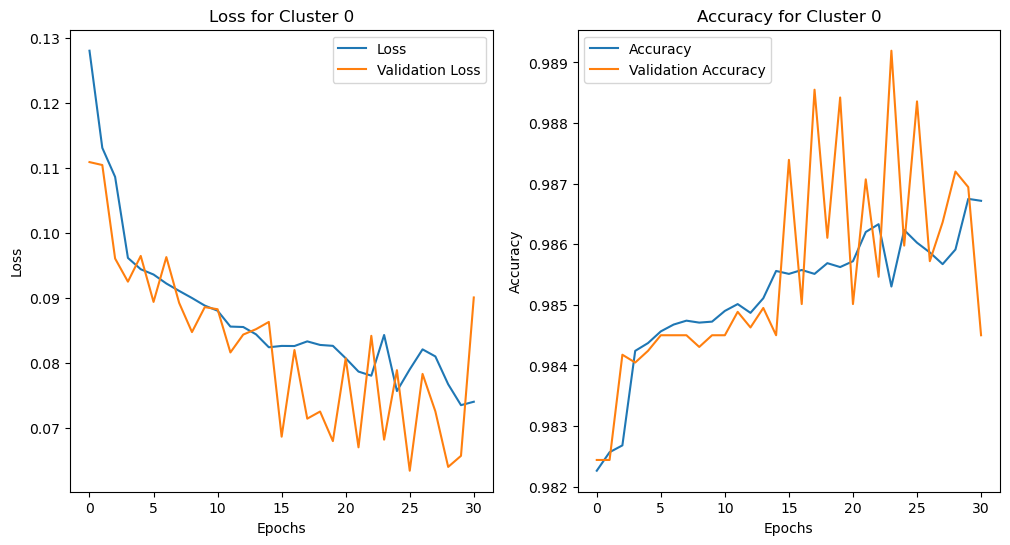

Model for cluster 0 saved to LSTM_Model/model_cluster_0.h5
Training model for cluster 1
Epoch 1/50


c:\Users\MSI\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4664/4664 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9628 - loss: 0.2519 - val_accuracy: 0.9620 - val_loss: 0.1960
Epoch 2/50
4664/4664 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9646 - loss: 0.1806 - val_accuracy: 0.9699 - val_loss: 0.1461
Epoch 3/50
4664/4664 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9694 - loss: 0.1527 - val_accuracy: 0.9698 - val_loss: 0.1454
Epoch 4/50
4664/4664 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9706 - loss: 0.1468 - val_accuracy: 0.9698 - val_loss: 0.1512
Epoch 5/50
4664/4664 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9699 - loss: 0.1476 - val_accuracy: 0.9696 - val_loss: 0.1459
Epoch 6/50
4664/4664 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9701 - loss: 0.1462 - val_accuracy: 0.9698 - val_loss: 0.1461
Epoch 7/50
4664/4664 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9706 - loss: 0.1455 - val_accuracy: 0.9698 - val_loss: 0.1466
Epoch 8/50
4664/4664 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9704 - loss: 0.1448 - val

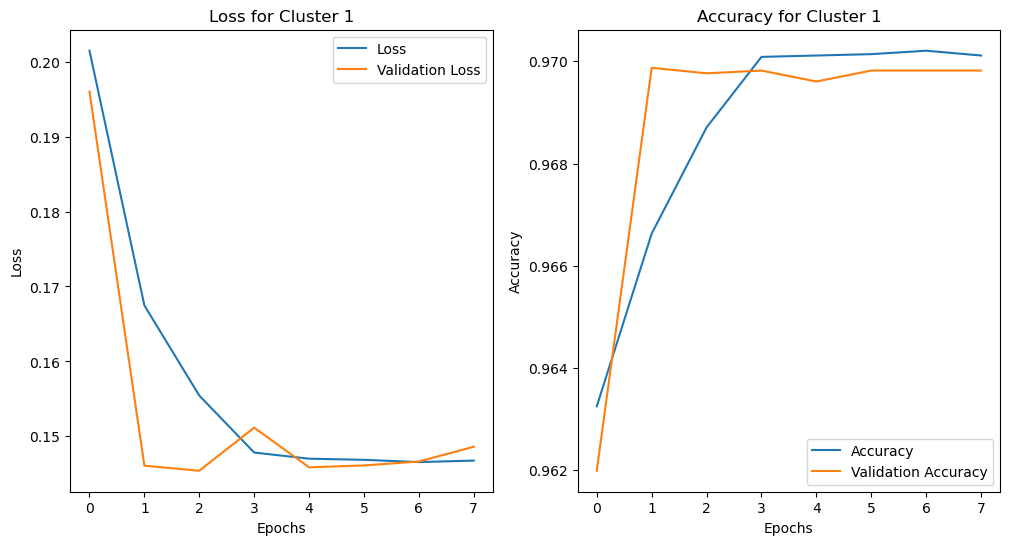

Model for cluster 1 saved to LSTM_Model/model_cluster_1.h5
Training model for cluster 2
Epoch 1/50


c:\Users\MSI\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7405/7405 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.9809 - loss: 0.1505 - val_accuracy: 0.9867 - val_loss: 0.0757
Epoch 2/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9870 - loss: 0.0759 - val_accuracy: 0.9869 - val_loss: 0.0750
Epoch 3/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9870 - loss: 0.0752 - val_accuracy: 0.9869 - val_loss: 0.0736
Epoch 4/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.9871 - loss: 0.0745 - val_accuracy: 0.9869 - val_loss: 0.0715
Epoch 5/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9877 - loss: 0.0683 - val_accuracy: 0.9868 - val_loss: 0.0692
Epoch 6/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9874 - loss: 0.0683 - val_accuracy: 0.9874 - val_loss: 0.0669
Epoch 7/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.9878 - loss: 0.0663 - val_accuracy: 0.9873 - val_loss: 0.0662
Epoch 8/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.9874 - loss: 0.0679 - val

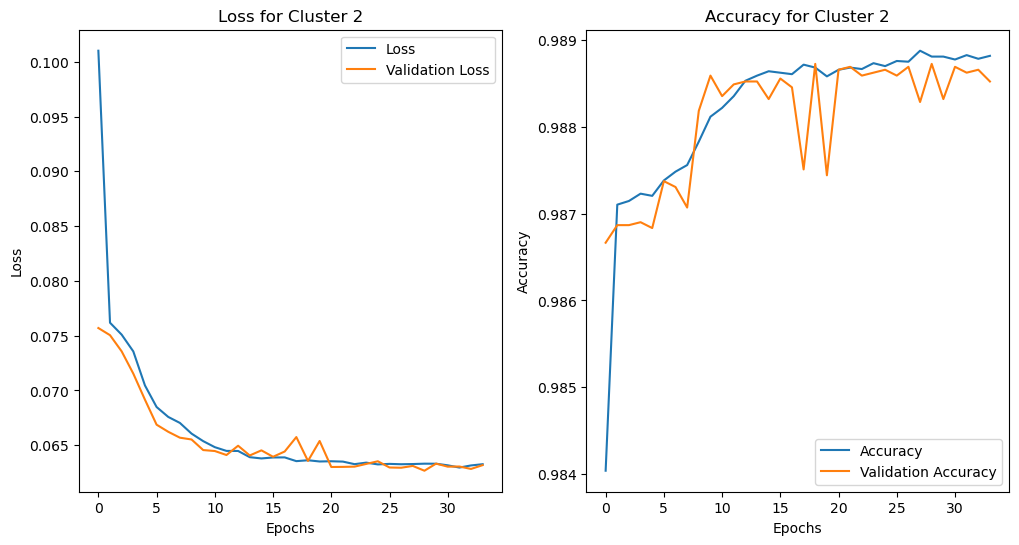

Model for cluster 2 saved to LSTM_Model/model_cluster_2.h5


In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import load_model
import os

# Récupération des clusters uniques
clusters = data['cluster'].unique()

# Boucle pour entraîner un modèle pour chaque cluster
for cluster in clusters:
    print(f"Training model for cluster {cluster}")
    
    # Filtrer les données pour le cluster actuel
    cluster_data = data[data['cluster'] == cluster]
    
    # Créer les séquences et les labels pour le cluster
    X, y = create_sequences(cluster_data, window_size)
    
    # Reshaper les séquences pour LSTM (ajouter la dimension pour les caractéristiques)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Créer le modèle LSTM
    num_classes = len(np.unique(y))  # Nombre de classes = labels uniques dans y
    model = create_lstm_model(window_size, num_classes)
    
    # Callback EarlyStopping pour éviter le surapprentissage
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Entraîner le modèle et sauvegarder l'historique pour les graphiques
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    # Évaluer le modèle
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Obtenir la classe avec la probabilité la plus élevée
    
    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)

    print(f"Accuracy for cluster {cluster}: {accuracy}")
    print(f"Precision for cluster {cluster}: {precision}")
    print(f"Recall for cluster {cluster}: {recall}")

    # Affichage des graphiques : perte et précision
    plt.figure(figsize=(12, 6))

    # Graphe de la perte
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Loss for Cluster {cluster}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Graphe de l'exactitude
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy for Cluster {cluster}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

   # Save the model for the current cluster locally
    model_save_path = f"LSTM_Model/model_cluster_{cluster}.h5"  # Change this to your desired directory path
    model.save(model_save_path)  # Save the model to the file
    print(f"Model for cluster {cluster} saved to {model_save_path}")


Random forest

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Charger le fichier CSV
data = pd.read_csv('all_data_for_users_with_anomalies.csv')


In [21]:
# Convertir la colonne 'datetime' en format datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.sort_values(by=['user_number', 'datetime'])
# Remplacer les NaN dans 'type' par 'pas d'anomalie'
data['type'] = data['type'].fillna('pas d\'anomalie')
# Normalisation des consommations
scaler = MinMaxScaler()
data['normalized_consumption'] = scaler.fit_transform(data[['Consommation']])
# Encoder les labels (les types d'anomalies) en traitant les valeurs manquantes
label_encoder = LabelEncoder()
data['encoded_type'] = label_encoder.fit_transform(data['type'].fillna('missing'))
# Afficher les types et leur encodage
print("Type d'anomalie et leur encodage :")
for type_value, encoded_value in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{type_value} -> {encoded_value}")

Type d'anomalie et leur encodage :
Coupure d'eau -> 0
Fuite de consommation -> 1
Surconsommation -> 2
pas d'anomalie -> 3
prb de compteur -> 4
prb de retour d/eau -> 5


In [22]:
# Create features for Random Forest
def create_features(data):
    # You can add more features if needed
    return data[['normalized_consumption', 'encoded_type']].values

# Cluster handling and model training
clusters = data['cluster'].unique()
clusters
data

,user_number,datetime,Consommation,cluster,anomalie,type,normalized_consumption,encoded_type
0,0_39,2016-03-01 01:02:47,7,0,0,pas d'anomalie,0.204889,3
1,0_39,2016-03-01 02:02:47,8,0,0,pas d'anomalie,0.205019,3
2,0_39,2016-03-01 03:02:45,3,0,0,pas d'anomalie,0.204372,3
3,0_39,2016-03-01 04:02:45,0,0,0,pas d'anomalie,0.203984,3
4,0_39,2016-03-01 05:02:45,0,0,0,pas d'anomalie,0.203984,3
...,...,...,...,...,...,...,...,...
319104,2_75,2017-02-12 19:53:03,0,2,0,pas d'anomalie,0.203984,3
319105,2_75,2017-02-12 20:53:03,0,2,0,pas d'anomalie,0.203984,3
319106,2_75,2017-02-12 21:53:02,0,2,0,pas d'anomalie,0.203984,3
319107,2_75,2017-02-12 22:53:02,0,2,0,pas d'anomalie,0.203984,3


In [23]:
# Function to create overlapping sequences for the given window size
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(0, len(data) - window_size, window_size // 2):  # Create overlap (shift by half the window size)
        X.append(data.iloc[i:i + window_size]['normalized_consumption'].values)
        y.append(data.iloc[i + window_size]['encoded_type'])  # Label for the last value in the window
    return np.array(X), np.array(y)

# Clusters handling and model training
clusters = data['cluster'].unique()
clusters

array([0, 1, 2], dtype=int64)

Training model for cluster 0
Accuracy for cluster 0: 0.9904810908155389
Precision for cluster 0: 0.9854171180021494
Recall for cluster 0: 0.9904810908155389


C:\Users\MSI\AppData\Local\Temp\ipykernel_18352\35719240.py:46: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


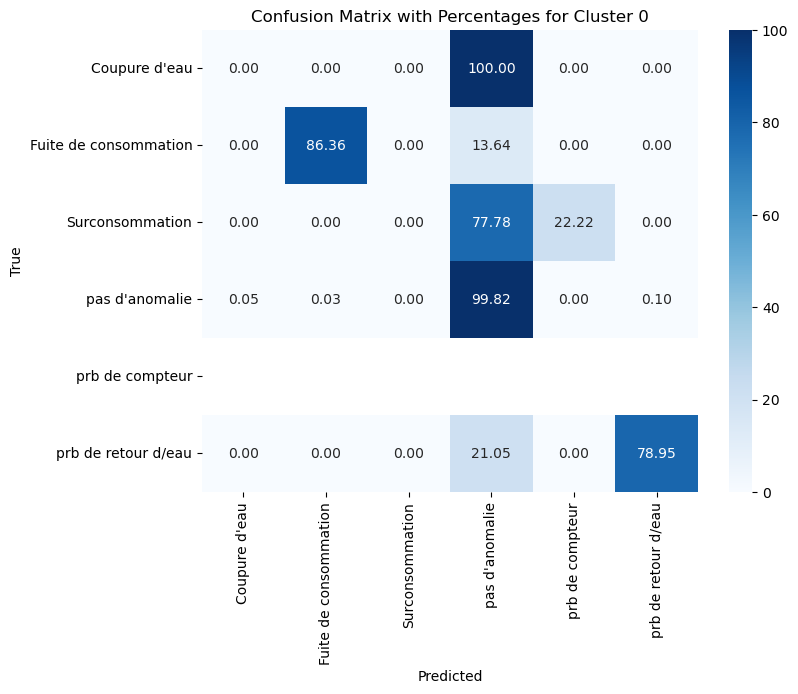

Random Forest model for cluster 0 saved to RandomForest/model_cluster_00.pkl
Training model for cluster 1
Accuracy for cluster 1: 0.9713734319716951
Precision for cluster 1: 0.9697708926112868
Recall for cluster 1: 0.9713734319716951


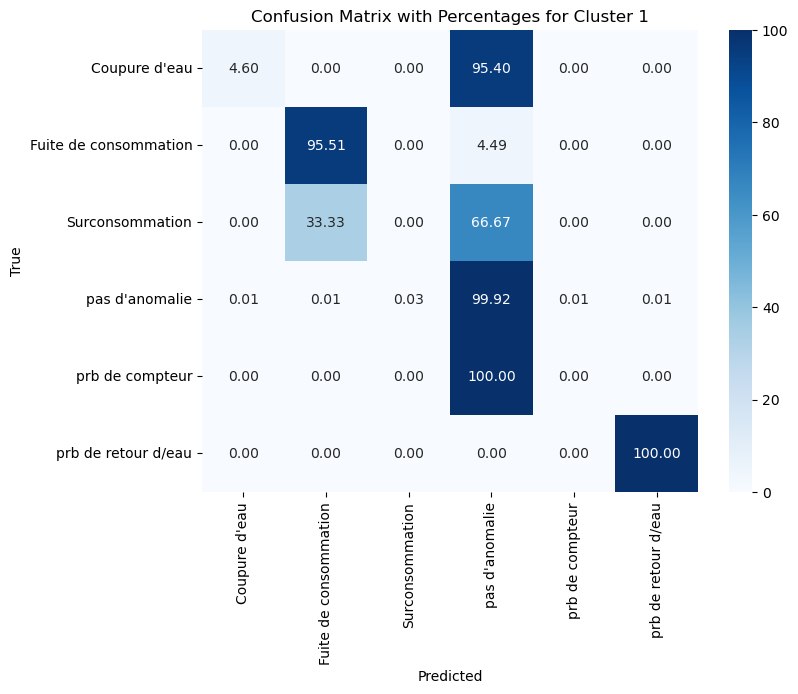

Random Forest model for cluster 1 saved to RandomForest/model_cluster_11.pkl
Training model for cluster 2
Accuracy for cluster 2: 0.9911546252532073
Precision for cluster 2: 0.9893862495476438
Recall for cluster 2: 0.9911546252532073


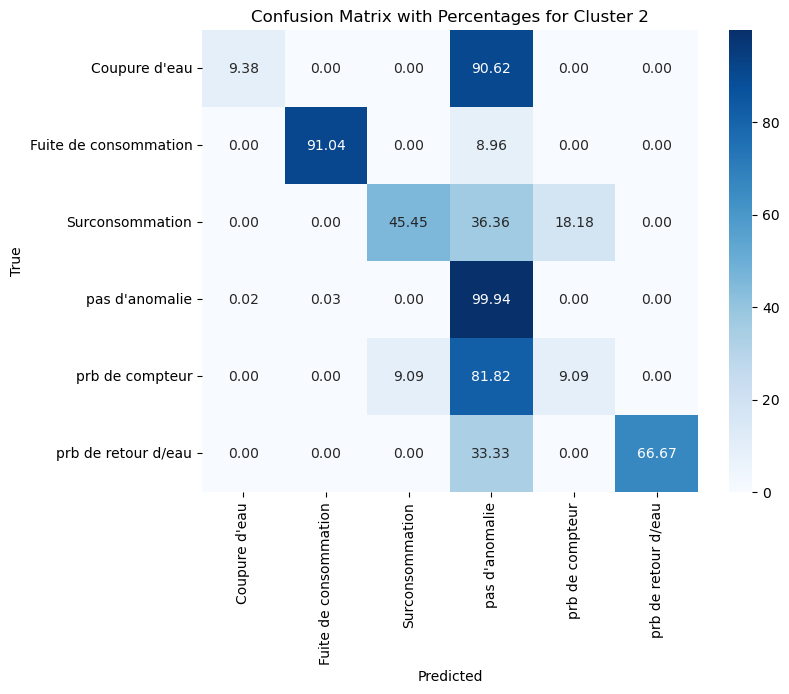

Random Forest model for cluster 2 saved to RandomForest/model_cluster_22.pkl


In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for cluster in clusters:
    print(f"Training model for cluster {cluster}")
    
    # Filter data for the current cluster
    cluster_data = data[data['cluster'] == cluster]
    
    # Parameters
    window_size = 4  # Example window size for the sequences
    
    # Create sequences and labels for the cluster
    X, y = create_sequences(cluster_data, window_size)
    
    # Flatten the X data for Random Forest (no need for reshaping like LSTM)
    X = X.reshape(X.shape[0], X.shape[1])  # Flatten to 2D array: (num_samples, window_size)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy for cluster {cluster}: {accuracy}")
    print(f"Precision for cluster {cluster}: {precision}")
    print(f"Recall for cluster {cluster}: {recall}")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalize confusion matrix to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix with Percentages for Cluster {cluster}')
    plt.show()

    # Save the model for the current cluster in the /kaggle/working/ directory
    model_save_path = f"RandomForest/model_cluster_{cluster}{cluster}.pkl"
    import joblib
    joblib.dump(model, model_save_path)  # Save the model as a .pkl file
    print(f"Random Forest model for cluster {cluster} saved to {model_save_path}")
    
  

In [28]:
import numpy as np

# Charger un modèle pour un cluster donné
#model_path = "RandomForest\model_cluster_22.pkl"
loaded_model = joblib.load(model_path)

# Décoder les types d'anomalies pour la prédiction
def predict_sequences(loaded_model, sequences, label_encoder):
    predicted_types = []
    for seq in sequences:
        # Reshaper la séquence en 2D pour l'entrée du modèle
        seq_reshaped = np.array(seq).reshape(1, -1)
        
        # Prédire le label
        predicted_label = loaded_model.predict(seq_reshaped)
        
        # Décoder le label en type d'anomalie
        predicted_type = label_encoder.inverse_transform(predicted_label)
        predicted_types.append(predicted_type[0])
    return predicted_types

# Exemple de séquences de test (chaque séquence est un type d'anomalie)
# Ces séquences doivent être normalisées
test_sequences = [
    [800, 500, 800, 900], 
    [800, 500, 800, 900], 
    [200, 100, -800, 100], 
    [-800, -500, -800, -900], 
    [15, 25, 35, 50],  
    [5, 0, 1000, 30]    
]

# Normaliser chaque valeur de la séquence avec le même scaler utilisé pour entraîner le modèle
normalized_test_sequences = []
for seq in test_sequences:
    normalized_seq = scaler.transform(np.array(seq).reshape(-1, 1)).flatten()  # Normalisation élément par élément
    normalized_test_sequences.append(normalized_seq)

# Prédire les types d'anomalies pour les séquences normalisées
predicted_types = predict_sequences(loaded_model, normalized_test_sequences, label_encoder)

# Afficher les résultats
for i, (original_seq, normalized_seq) in enumerate(zip(test_sequences, normalized_test_sequences)):
    print(f"Sequence originale {i+1}: {original_seq}")
    print(f"Sequence normalisée {i+1}: {normalized_seq}")
    print(f"Predicted Type: {predicted_types[i]}")


Sequence originale 1: [800, 500, 800, 900]
Sequence normalisée 1: [0.30746346 0.26865865 0.30746346 0.3203984 ]
Predicted Type: Fuite de consommation
Sequence originale 2: [800, 500, 800, 900]
Sequence normalisée 2: [0.30746346 0.26865865 0.30746346 0.3203984 ]
Predicted Type: Fuite de consommation
Sequence originale 3: [200, 100, -800, 100]
Sequence normalisée 3: [0.22985384 0.2169189  0.10050446 0.2169189 ]
Predicted Type: pas d'anomalie
Sequence originale 4: [-800, -500, -800, -900]
Sequence normalisée 4: [0.10050446 0.13930927 0.10050446 0.08756953]
Predicted Type: prb de retour d/eau
Sequence originale 5: [15, 25, 35, 50]
Sequence normalisée 5: [0.2059242  0.20721769 0.20851119 0.21045143]
Predicted Type: pas d'anomalie
Sequence originale 6: [5, 0, 1000, 30]
Sequence normalisée 6: [0.20463071 0.20398396 0.33333333 0.20786444]
Predicted Type: pas d'anomalie


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\MSI\AppData\Local\Temp\ipykernel_18352\2333100030.py:4: SyntaxWarning: invalid escape sequence '\m'
  model_path = "RandomForest\model_cluster_22.pkl"
c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\MSI\anaconda3\Lib\site-pack